<a href="https://colab.research.google.com/github/ernanibn/redes_neurais_artificiais/blob/main/atividade_3_forecasting_Ernani_Brand%C3%A3o_Nascimento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Download the dataset
!kaggle datasets download -d nicholasjhana/energy-consumption-generation-prices-and-weather

# Unzip the downloaded dataset
!unzip energy-consumption-generation-prices-and-weather.zip

Dataset URL: https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather
License(s): CC0-1.0
  0% 0.00/3.81M [00:00<?, ?B/s]
100% 3.81M/3.81M [00:00<00:00, 166MB/s]
Archive:  energy-consumption-generation-prices-and-weather.zip
  inflating: energy_dataset.csv      
  inflating: weather_features.csv    


In [ ]:
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
fname = os.path.join("energy_dataset.csv")
with open(fname) as f:
  data = f.read()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

# Remover linhas totalmente vazias
lines = [line for line in lines if line.strip()]

header = header[1:]

index_1 = header.index('generation hydro pumped storage aggregated')
index_2 = header.index('generation wind offshore')-1
index_3 = header.index('forecast wind offshore eday ahead')-2

del header[index_1]
del header[index_2]
del header[index_3]

print(header)
print(len(lines))

['generation biomass', 'generation fossil brown coal/lignite', 'generation fossil coal-derived gas', 'generation fossil gas', 'generation fossil hard coal', 'generation fossil oil', 'generation fossil oil shale', 'generation fossil peat', 'generation geothermal', 'generation hydro pumped storage consumption', 'generation hydro run-of-river and poundage', 'generation hydro water reservoir', 'generation marine', 'generation nuclear', 'generation other', 'generation other renewable', 'generation solar', 'generation waste', 'generation wind onshore', 'forecast solar day ahead', 'forecast wind onshore day ahead', 'total load forecast', 'total load actual', 'price day ahead', 'price actual']
35064


In [ ]:
# Número de linhas de dados
num_lines = len(lines)

# Função para limpar e converter valor para float
def clean_and_convert(value):
    # Remover espaços em branco, aspas duplas e símbolo de porcentagem (%)
    cleaned_value = value.replace('"', '').replace('%', '').strip()
    # return float(cleaned_value)
    if cleaned_value == '':
      x = None
    else:
      x = float(cleaned_value)
    return x  # Converter para float

# Inicializar arrays para temperatura (target) e dados brutos
price = np.zeros(num_lines)
raw_data = np.zeros((num_lines, len(header)-1))  # Excluindo o campo 'Price' da matriz de dados

j=0
index_to_remove = []
for i, line in enumerate(lines):
#     # Dividir a linha em valores separados por vírgula
    values = line.split(',')[1:]  # Ignorar os dois primeiros valores

#     # Limpar e converter cada valor para float
    cleaned_values = [clean_and_convert(val) for val in values]
    del cleaned_values[index_1]
    del cleaned_values[index_2]
    del cleaned_values[index_3]
    if any(x is None for x in cleaned_values):
      index_to_remove += [i]
    else:
  #     # Armazenar o valor 'Price' na array temperature
      price[j] = cleaned_values[len(cleaned_values)-1]  # 'Price' é o primeiro valor na lista 'cleaned_values'
  #     # Armazenar os outros valores na matriz raw_data
      raw_data[j, :] = cleaned_values[:len(cleaned_values)-1]  # Excluir o 'Price' e armazenar os demais valores
      j+=1
    # test_raw.append(cleaned_values[:])


# # # Verificar as dimensões finais dos dados
print("Dimensão da price (target):", price.shape)
price = price[price != 0]
print("Dimensão da price (target):", price.shape)
print("Dimensão dos dados brutos:", raw_data.shape)

# Gerar uma lista de índices das linhas que serão mantidas
indices_para_manter = [i for i in range(raw_data.shape[0]) if i not in index_to_remove]
# Criar uma nova matriz contendo apenas as linhas que você deseja manter
raw_data = raw_data[indices_para_manter]
print("Dimensão dos dados brutos:", raw_data.shape)

index_1 = header.index('generation fossil coal-derived gas')
index_2 = header.index('generation fossil oil shale')
index_3 = header.index('generation fossil peat')
index_4 = header.index('generation geothermal')
index_5 = header.index('generation marine')

del header[index_1]
del header[index_2]
del header[index_3]
del header[index_4]
del header[index_5]

media_colunas = np.mean(raw_data, axis=0)
print(media_colunas)

# Índice da coluna que você deseja remover
indice_coluna_remover = [index_1, index_2, index_3, index_4, index_5]

# Criar uma nova matriz sem a coluna especificada
raw_data = np.delete(raw_data, indice_coluna_remover, axis=1)
media_colunas = np.mean(raw_data, axis=0)
print(media_colunas)



Dimensão da price (target): (35064,)
Dimensão da price (target): (35017,)
Dimensão dos dados brutos: (35064, 24)
Dimensão dos dados brutos: (35017, 24)
[  382.96778707   447.5966245      0.          5615.03892395
  4249.39817803   297.9293486      0.             0.
     0.           475.30142502   970.54927607  2600.23922666
     0.          6255.90016278    60.15518177    85.54879059
  1430.69900334   269.2195505   5458.22794643  1436.84870206
  5463.98466459 28671.22466231 28657.02524488    49.80253277]
[  382.96778707   447.5966245   5615.03892395  4249.39817803
   297.9293486    475.30142502   970.54927607  2600.23922666
  6255.90016278    60.15518177    85.54879059  1430.69900334
   269.2195505   5458.22794643  1436.84870206  5463.98466459
 28671.22466231 28657.02524488    49.80253277]


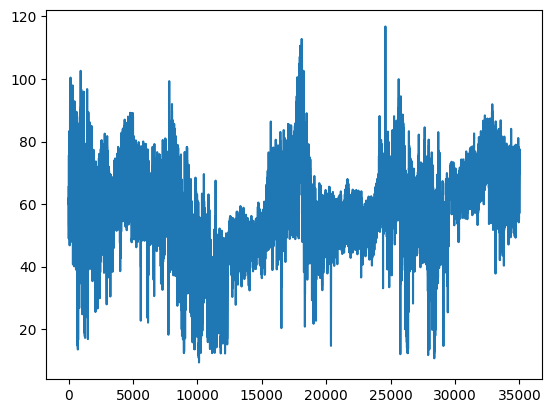

In [ ]:
plt.plot(range(len(price)), price)

In [ ]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
(num_train_samples, num_val_samples, num_test_samples)

(17508, 8754, 8755)

In [ ]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [ ]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 + 1)
batch_size = 256
train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = price[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    end_index = num_train_samples)
val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = price[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = num_train_samples,
    end_index = num_train_samples + num_val_samples)
test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = price[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = num_train_samples + num_val_samples)

In [ ]:
for samples, targets in train_dataset:
  print("samples shape", samples.shape)
  print("targets shape", targets.shape)
  break

samples shape (256, 120, 19)
targets shape (256,)


## Baseline

In [ ]:
def evaluate_naive_method(dataset):
  total_abs_err = 0.
  samples_seen = 0
  for samples, targets in dataset:
    preds = samples[:, -1, 1] * std[1] + mean[1]
    total_abs_err += np.sum(np.abs(preds - targets))
    samples_seen += samples.shape[0]
  return total_abs_err / samples_seen
print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 485.22
Test MAE: 330.40


In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("dollar_index_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=['mae'])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data = val_dataset,
                    callbacks = callbacks)
model = keras.models.load_model("dollar_index_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
66/66 [==============================] - 5s 70ms/step - loss: 1338.0244 - mae: 32.1048 - val_loss: 301.5240 - val_mae: 14.8128
Epoch 2/10
66/66 [==============================] - 4s 51ms/step - loss: 176.4788 - mae: 10.1919 - val_loss: 661.2496 - val_mae: 23.0614
Epoch 3/10
66/66 [==============================] - 4s 55ms/step - loss: 62.5399 - mae: 6.1151 - val_loss: 622.3388 - val_mae: 22.0282
Epoch 4/10
66/66 [==============================] - 4s 57ms/step - loss: 42.8383 - mae: 5.0916 - val_loss: 692.1279 - val_mae: 23.4773
Epoch 5/10
66/66 [==============================] - 4s 54ms/step - loss: 33.2080 - mae: 4.4889 - val_loss: 702.9723 - val_mae: 23.5872
Epoch 6/10
66/66 [==============================] - 5s 71ms/step - loss: 27.3349 - mae: 4.0735 - val_loss: 689.2937 - val_mae: 23.2746
Epoch 7/10
66/66 [==============================] - 4s 52ms/step - loss: 23.5541 - mae: 3.7941 - val_loss: 741.5631 - val_mae: 24.0920
Epoch 8/10
66/66 [==============================] 

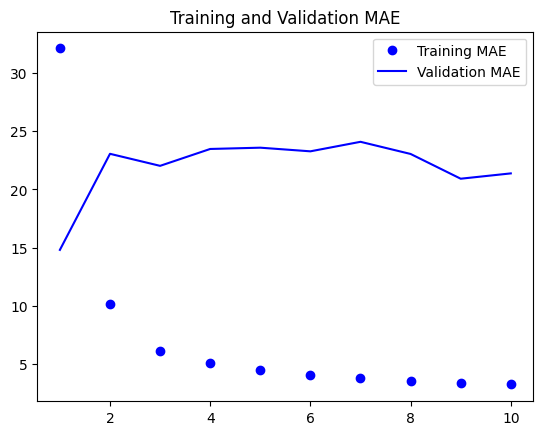

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss)+1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and Validation MAE")
plt.legend()
plt.show()

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("dollar_index_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=['mae'])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data = val_dataset,
                    callbacks = callbacks)
model = keras.models.load_model("dollar_index_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
66/66 [==============================] - 11s 145ms/step - loss: 1205.2673 - mae: 27.4294 - val_loss: 163.4628 - val_mae: 9.5302
Epoch 2/10
66/66 [==============================] - 8s 110ms/step - loss: 124.1566 - mae: 8.6900 - val_loss: 167.6811 - val_mae: 9.7828
Epoch 3/10
66/66 [==============================] - 8s 120ms/step - loss: 113.6134 - mae: 8.3102 - val_loss: 245.6411 - val_mae: 12.3028
Epoch 4/10
66/66 [==============================] - 9s 133ms/step - loss: 107.3501 - mae: 8.0845 - val_loss: 197.9769 - val_mae: 10.8656
Epoch 5/10
66/66 [==============================] - 7s 104ms/step - loss: 102.3963 - mae: 7.9045 - val_loss: 299.5378 - val_mae: 13.9346
Epoch 6/10
66/66 [==============================] - 7s 101ms/step - loss: 98.7546 - mae: 7.8029 - val_loss: 178.1538 - val_mae: 10.1462
Epoch 7/10
66/66 [==============================] - 9s 138ms/step - loss: 95.5438 - mae: 7.6753 - val_loss: 228.4790 - val_mae: 11.6745
Epoch 8/10
66/66 [========================

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("dollar_index_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=['mae'])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data = val_dataset,
                    callbacks = callbacks)
model = keras.models.load_model("dollar_index_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
66/66 [==============================] - 13s 150ms/step - loss: 2983.1716 - mae: 52.6681 - val_loss: 3074.2859 - val_mae: 54.4948
Epoch 2/10
66/66 [==============================] - 9s 133ms/step - loss: 2599.2537 - mae: 48.8819 - val_loss: 2668.9622 - val_mae: 50.5977
Epoch 3/10
66/66 [==============================] - 8s 123ms/step - loss: 2368.3645 - mae: 46.3755 - val_loss: 2475.7656 - val_mae: 48.6495
Epoch 4/10
66/66 [==============================] - 8s 115ms/step - loss: 2225.3083 - mae: 44.7921 - val_loss: 2338.5603 - val_mae: 47.2177
Epoch 5/10
66/66 [==============================] - 9s 129ms/step - loss: 2111.3821 - mae: 43.4981 - val_loss: 2224.0444 - val_mae: 45.9885
Epoch 6/10
66/66 [==============================] - 8s 121ms/step - loss: 2009.6013 - mae: 42.3116 - val_loss: 2118.5234 - val_mae: 44.8264
Epoch 7/10
66/66 [==============================] - 9s 128ms/step - loss: 1913.9653 - mae: 41.1685 - val_loss: 2018.0826 - val_mae: 43.6928
Epoch 8/10
66/66 [=

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("dollar_index_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=['mae'])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data = val_dataset,
                    callbacks = callbacks)
model = keras.models.load_model("dollar_index_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
66/66 [==============================] - 20s 250ms/step - loss: 2717.1091 - mae: 49.9198 - val_loss: 2552.4304 - val_mae: 49.4321
Epoch 2/10
66/66 [==============================] - 17s 248ms/step - loss: 2228.1614 - mae: 44.7710 - val_loss: 2256.1045 - val_mae: 46.3366
Epoch 3/10
66/66 [==============================] - 19s 286ms/step - loss: 1996.5087 - mae: 42.0966 - val_loss: 2042.6049 - val_mae: 43.9725
Epoch 4/10
66/66 [==============================] - 17s 248ms/step - loss: 1812.8120 - mae: 39.8414 - val_loss: 1853.9062 - val_mae: 41.7774
Epoch 5/10
66/66 [==============================] - 16s 244ms/step - loss: 1641.9390 - mae: 37.6743 - val_loss: 1677.6910 - val_mae: 39.6227
Epoch 6/10
66/66 [==============================] - 17s 255ms/step - loss: 1486.3593 - mae: 35.5723 - val_loss: 1511.5642 - val_mae: 37.4850
Epoch 7/10
66/66 [==============================] - 17s 252ms/step - loss: 1343.7916 - mae: 33.5432 - val_loss: 1355.1901 - val_mae: 35.3605
Epoch 8/10
66

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("dollar_index_lstm_bidirectional.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=['mae'])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data = val_dataset,
                    callbacks = callbacks)
model = keras.models.load_model("dollar_index_lstm_bidirectional.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
66/66 [==============================] - 18s 199ms/step - loss: 2919.9233 - mae: 52.0172 - val_loss: 2864.5469 - val_mae: 52.5173
Epoch 2/10
66/66 [==============================] - 12s 181ms/step - loss: 2381.3350 - mae: 46.5415 - val_loss: 2360.0432 - val_mae: 47.4502
Epoch 3/10
66/66 [==============================] - 13s 188ms/step - loss: 2033.7544 - mae: 42.6065 - val_loss: 2062.9561 - val_mae: 44.2050
Epoch 4/10
66/66 [==============================] - 13s 192ms/step - loss: 1799.2101 - mae: 39.7623 - val_loss: 1838.3136 - val_mae: 41.5921
Epoch 5/10
66/66 [==============================] - 13s 186ms/step - loss: 1610.9146 - mae: 37.3491 - val_loss: 1648.6543 - val_mae: 39.2574
Epoch 6/10
66/66 [==============================] - 13s 188ms/step - loss: 1446.3560 - mae: 35.1296 - val_loss: 1477.9264 - val_mae: 37.0382
Epoch 7/10
66/66 [==============================] - 13s 191ms/step - loss: 1296.6517 - mae: 33.0151 - val_loss: 1320.8352 - val_mae: 34.8779
Epoch 8/10
66